In [13]:
# Import library yang dibutuhkan dan load dataset.
import pandas as pd
import numpy as np

# Membaca file CSV ke DataFrame
df = pd.read_csv('data/student_data.csv')
df.head()  # Menampilkan 5 data teratas untuk memastikan data berhasil dimuat

,Student_ID,First_Name,Last_Name,Email,Gender,Age,Department,Attendance (%),Midterm_Score,Final_Score,...,Projects_Score,Total_Score,Grade,Study_Hours_per_Week,Extracurricular_Activities,Internet_Access_at_Home,Parent_Education_Level,Family_Income_Level,Stress_Level (1-10),Sleep_Hours_per_Night
0,S1000,Omar,Williams,student0@university.com,Female,22,Mathematics,97.36,40.61,59.61,...,62.84,83.49,C,10.3,Yes,No,Master's,Medium,1,5.9
1,S1001,Maria,Brown,student1@university.com,Male,18,Business,97.71,57.27,74.00,...,98.23,92.29,F,27.1,No,No,High School,Low,4,4.3
2,S1002,Ahmed,Jones,student2@university.com,Male,24,Engineering,99.52,41.84,63.85,...,91.22,93.55,F,12.4,Yes,No,High School,Low,9,6.1
3,S1003,Omar,Williams,student3@university.com,Female,24,Engineering,90.38,45.65,44.44,...,55.48,51.03,A,25.5,No,Yes,High School,Low,8,4.9
4,S1004,John,Smith,student4@university.com,Female,23,CS,59.41,53.13,61.77,...,87.43,90.91,A,13.3,Yes,No,Master's,Medium,6,4.5


In [14]:
# Memilih fitur yang relevan untuk sistem fuzzy: kehadiran, nilai total, nilai proyek, dan grade.
features = ['Attendance (%)', 'Total_Score', 'Projects_Score', 'Grade']
df = df[features]

# Mengecek apakah ada missing value pada fitur yang dipilih
print("Jumlah missing value per kolom:")
print(df.isnull().sum())
print("\nStatistik deskriptif:")
display(df.describe())

Jumlah missing value per kolom:
Attendance (%)    0
Total_Score       0
Projects_Score    0
Grade             0
dtype: int64

Statistik deskriptif:


,Attendance (%),Total_Score,Projects_Score
count,5000.000000,5000.000000,5000.00000
mean,75.356076,75.021860,74.78305
std,14.392716,14.323246,14.54243
min,50.010000,50.010000,50.00000
25%,62.945000,62.710000,61.97000
50%,75.670000,75.345000,74.54000
75%,87.862500,87.060000,87.63000
max,100.000000,99.990000,100.00000


In [15]:
# Mengisi missing value pada fitur numerik dengan rata-rata kolom tersebut
for col in ['Attendance (%)', 'Total_Score', 'Projects_Score']:
    df[col] = df[col].fillna(df[col].mean())

# Mengubah Grade (A/B/C/D/F) menjadi nilai numerik untuk evaluasi
grade_map = {'A': 90, 'B': 80, 'C': 70, 'D': 60, 'F': 50}
df['Grade_num'] = df['Grade'].map(grade_map)

# Menghapus baris jika ada grade yang tidak dikenali (NaN setelah mapping)
df = df.dropna(subset=['Grade_num'])

# Menampilkan 5 data teratas setelah prapemrosesan
df.head()

,Attendance (%),Total_Score,Projects_Score,Grade,Grade_num
0,97.36,83.49,62.84,C,70
1,97.71,92.29,98.23,F,50
2,99.52,93.55,91.22,F,50
3,90.38,51.03,55.48,A,90
4,59.41,90.91,87.43,A,90


In [16]:
# Definisikan Fuzzy System Mamdani
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Definisikan variabel fuzzy
attendance = ctrl.Antecedent(np.arange(0, 101, 1), 'attendance')
total_score = ctrl.Antecedent(np.arange(0, 101, 1), 'total_score')
projects_score = ctrl.Antecedent(np.arange(0, 101, 1), 'projects_score')
performance = ctrl.Consequent(np.arange(0, 101, 1), 'performance')

# Membership function sesuai README
attendance['low'] = fuzz.trimf(attendance.universe, [0, 0, 50])
attendance['medium'] = fuzz.trimf(attendance.universe, [0, 50, 100])
attendance['high'] = fuzz.trimf(attendance.universe, [50, 100, 100])

total_score['low'] = fuzz.trimf(total_score.universe, [0, 0, 50])
total_score['medium'] = fuzz.trimf(total_score.universe, [0, 50, 100])
total_score['high'] = fuzz.trimf(total_score.universe, [50, 100, 100])

projects_score['few'] = fuzz.trimf(projects_score.universe, [0, 0, 50])
projects_score['average'] = fuzz.trimf(projects_score.universe, [0, 50, 100])
projects_score['many'] = fuzz.trimf(projects_score.universe, [50, 100, 100])

performance['poor'] = fuzz.trimf(performance.universe, [0, 0, 50])
performance['average'] = fuzz.trimf(performance.universe, [0, 50, 100])
performance['good'] = fuzz.trimf(performance.universe, [50, 100, 100])

In [17]:
# Aturan Fuzzy Mamdani
rules = [
    ctrl.Rule(attendance['low'] & total_score['low'] & projects_score['few'], performance['poor']),
    ctrl.Rule(attendance['low'] & total_score['low'] & projects_score['average'], performance['poor']),
    ctrl.Rule(attendance['low'] & total_score['low'] & projects_score['many'], performance['average']),
    ctrl.Rule(attendance['low'] & total_score['medium'] & projects_score['few'], performance['poor']),
    ctrl.Rule(attendance['low'] & total_score['medium'] & projects_score['average'], performance['average']),
    ctrl.Rule(attendance['low'] & total_score['medium'] & projects_score['many'], performance['average']),
    ctrl.Rule(attendance['low'] & total_score['high'] & projects_score['few'], performance['average']),
    ctrl.Rule(attendance['low'] & total_score['high'] & projects_score['average'], performance['average']),
    ctrl.Rule(attendance['low'] & total_score['high'] & projects_score['many'], performance['good']),
    
    ctrl.Rule(attendance['medium'] & total_score['low'] & projects_score['few'], performance['poor']),
    ctrl.Rule(attendance['medium'] & total_score['low'] & projects_score['average'], performance['average']),
    ctrl.Rule(attendance['medium'] & total_score['low'] & projects_score['many'], performance['average']),
    ctrl.Rule(attendance['medium'] & total_score['medium'] & projects_score['few'], performance['average']),
    ctrl.Rule(attendance['medium'] & total_score['medium'] & projects_score['average'], performance['average']),
    ctrl.Rule(attendance['medium'] & total_score['medium'] & projects_score['many'], performance['good']),
    ctrl.Rule(attendance['medium'] & total_score['high'] & projects_score['few'], performance['average']),
    ctrl.Rule(attendance['medium'] & total_score['high'] & projects_score['average'], performance['good']),
    ctrl.Rule(attendance['medium'] & total_score['high'] & projects_score['many'], performance['good']),
    
    ctrl.Rule(attendance['high'] & total_score['low'] & projects_score['few'], performance['average']),
    ctrl.Rule(attendance['high'] & total_score['low'] & projects_score['average'], performance['average']),
    ctrl.Rule(attendance['high'] & total_score['low'] & projects_score['many'], performance['good']),
    ctrl.Rule(attendance['high'] & total_score['medium'] & projects_score['few'], performance['average']),
    ctrl.Rule(attendance['high'] & total_score['medium'] & projects_score['average'], performance['good']),
    ctrl.Rule(attendance['high'] & total_score['medium'] & projects_score['many'], performance['good']),
    ctrl.Rule(attendance['high'] & total_score['high'] & projects_score['few'], performance['good']),
    ctrl.Rule(attendance['high'] & total_score['high'] & projects_score['average'], performance['good']),
    ctrl.Rule(attendance['high'] & total_score['high'] & projects_score['many'], performance['good']),
]

mamdani_ctrl = ctrl.ControlSystem(rules)
mamdani_sim = ctrl.ControlSystemSimulation(mamdani_ctrl)

In [ ]:
# Membuat prediksi Sugeno secara manual dengan fungsi linear dari input.
def sugeno_predict(row):
    # Bobot bisa diubah sesuai kebutuhan
    w1, w2, w3 = 0.3, 0.4, 0.3
    return w1 * row['Attendance (%)'] + w2 * row['Total_Score'] + w3 * row['Projects_Score']

df['Sugeno_pred'] = df.apply(sugeno_predict, axis=1)

# Tampilkan 5 hasil prediksi Sugeno pertama
df[['Attendance (%)', 'Total_Score', 'Projects_Score', 'Sugeno_pred']].head()

,Attendance (%),Total_Score,Projects_Score,Sugeno_pred
0,97.36,83.49,62.84,81.456
1,97.71,92.29,98.23,95.698
2,99.52,93.55,91.22,94.642
3,90.38,51.03,55.48,64.170
4,59.41,90.91,87.43,80.416


In [19]:
# Membuat fungsi untuk melakukan prediksi Mamdani pada setiap baris data.
def mamdani_predict(row):
    mamdani_sim.input['attendance'] = row['Attendance (%)']
    mamdani_sim.input['total_score'] = row['Total_Score']
    mamdani_sim.input['projects_score'] = row['Projects_Score']
    mamdani_sim.compute()
    return mamdani_sim.output['performance']

df['Mamdani_pred'] = df.apply(mamdani_predict, axis=1)

# Tampilkan 5 hasil prediksi Mamdani pertama
df[['Attendance (%)', 'Total_Score', 'Projects_Score', 'Mamdani_pred']].head()

,Attendance (%),Total_Score,Projects_Score,Mamdani_pred
0,97.36,83.49,62.84,76.068463
1,97.71,92.29,98.23,79.126663
2,99.52,93.55,91.22,81.772985
3,90.38,51.03,55.48,67.681840
4,59.41,90.91,87.43,67.687154


In [20]:
# Mengubah hasil prediksi (nilai 0-100) menjadi kelas Grade (A/B/C/D/F) berdasarkan threshold.
from sklearn.metrics import classification_report

def to_grade(val):
    if val >= 85: return 'A'
    elif val >= 75: return 'B'
    elif val >= 65: return 'C'
    elif val >= 55: return 'D'
    else: return 'F'

df['Mamdani_grade'] = df['Mamdani_pred'].apply(to_grade)
df['Sugeno_grade'] = df['Sugeno_pred'].apply(to_grade)

print("Mamdani Classification Report:")
print(classification_report(df['Grade'], df['Mamdani_grade']))
print("Sugeno Classification Report:")
print(classification_report(df['Grade'], df['Sugeno_grade']))

# Tampilkan perbandingan hasil prediksi dan aktual untuk 10 data pertama
df[['Grade', 'Mamdani_grade', 'Sugeno_grade', 'Mamdani_pred', 'Sugeno_pred']].head(10)

Mamdani Classification Report:
              precision    recall  f1-score   support

           A       0.00      0.00      0.00       997
           B       0.20      0.16      0.18      1014
           C       0.18      0.31      0.23       975
           D       0.21      0.43      0.29      1011
           F       0.22      0.10      0.14      1003

    accuracy                           0.20      5000
   macro avg       0.16      0.20      0.17      5000
weighted avg       0.16      0.20      0.17      5000

Sugeno Classification Report:
              precision    recall  f1-score   support

           A       0.22      0.14      0.17       997
           B       0.20      0.38      0.27      1014
           C       0.19      0.37      0.25       975
           D       0.19      0.11      0.14      1011
           F       0.32      0.01      0.01      1003

    accuracy                           0.20      5000
   macro avg       0.23      0.20      0.17      5000
weighted avg    

c:\Users\muham\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\muham\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\muham\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

,Grade,Mamdani_grade,Sugeno_grade,Mamdani_pred,Sugeno_pred
0,C,B,B,76.068463,81.456
1,F,B,A,79.126663,95.698
2,F,B,A,81.772985,94.642
3,A,C,D,67.681840,64.170
4,A,C,B,67.687154,80.416
5,D,C,B,68.453969,75.539
6,A,D,B,62.640600,78.268
7,F,D,B,63.425092,76.385
8,D,B,C,78.356434,68.840
9,C,C,B,65.244994,76.554


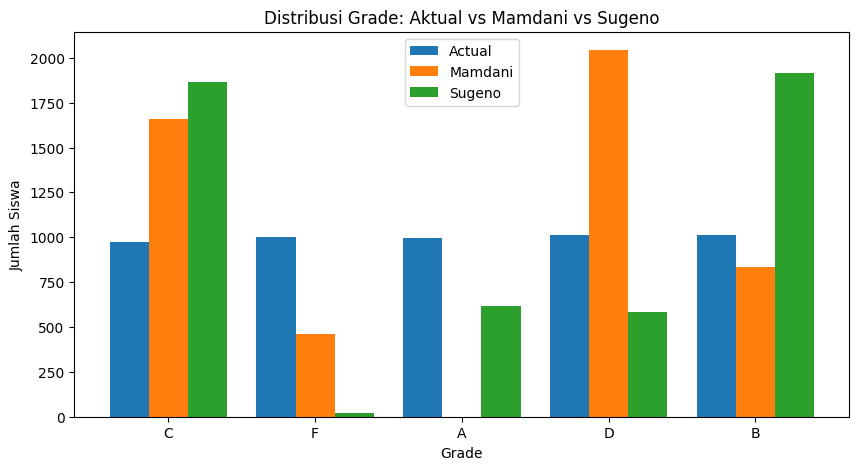

In [21]:
# Visualisasi distribusi grade aktual vs prediksi Mamdani dan Sugeno.
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist([df['Grade'], df['Mamdani_grade'], df['Sugeno_grade']], 
         label=['Actual', 'Mamdani', 'Sugeno'], bins=np.arange(6)-0.5, rwidth=0.8)
plt.xticks(list('ABCDF'))
plt.legend()
plt.title('Distribusi Grade: Aktual vs Mamdani vs Sugeno')
plt.xlabel('Grade')
plt.ylabel('Jumlah Siswa')
plt.show()